In [1]:
#setup
data_dir='../../../Data/Weather'
#!ls $data_dir
state='CA'
m='PRCP_s20'

In [2]:
# Enable automiatic reload of libraries
import pandas as pd
import seaborn as sns
import os
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

import findspark
findspark.init()

#import sys
#sys.path.append('./lib')

from lib.numpy_pack import packArray,unpackArray

#from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *


from lib.import_modules import import_modules,modules
import_modules(modules)

from lib.getFiles import *

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2

     numpy as    np 	version=1.11.3 	required version>=1.12.0
******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.3.0 	required version>=2.1.0

ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0
******* Update Version ******
version of ipwidgets= 5.2.2


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/decomposer.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)


In [6]:
get_weather_files(state,data_dir)
!du -h $data_dir

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/CA.tgz > ../../../Data/Weather/CA.tgz
tar -xzf ../../../Data/Weather/CA.tgz -C ../../../Data/Weather
rm ../../../Data/Weather/CA.tgz
curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_CA.pickle.gz > ../../../Data/Weather/STAT_CA.pickle.gz
gunzip ../../../Data/Weather/STAT_CA.pickle.gz
curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../../../Data/Weather/Weather_Stations.tgz
tar -xzf ../../../Data/Weather/Weather_Stations.tgz -C ../../../Data/Weather
rm ../../../Data/Weather/Weather_Stations.tgz
133M	../../../Data/Weather/CA.parquet
420K	../../../Data/Weather/stations.parquet
182M	../../../Data/Weather


In [7]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['SNWD', 'PRCP', 'TMAX_s20', 'TMAX', 'PRCP_s20', 'TMIN', 'SNOW_s20', 'TOBS_s20', 'TOBS', 'SNWD_s20', 'TMIN_s20', 'SNOW'])


In [8]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

In [12]:
#read data
filename='file:///mnt/workspace/Public-DSC291/Data/Weather/'+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

+-----------+-----------+----+--------------------+-----------------+--------------+----------------+---------+-----------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|       longitude|elevation|       name|
+-----------+-----------+----+--------------------+-----------------+--------------+----------------+---------+-----------+
|USC00040437|   PRCP_s20|1953|[00 00 00 00 00 0...|256.1050109863281|35.38330078125|-116.11669921875|    320.0|BAKER 9 NNW|
|USC00040437|   PRCP_s20|1954|[57 44 8B 44 BE 4...|256.1050109863281|35.38330078125|-116.11669921875|    320.0|BAKER 9 NNW|
|USC00040437|   PRCP_s20|1955|[59 43 5B 43 64 4...|256.1050109863281|35.38330078125|-116.11669921875|    320.0|BAKER 9 NNW|
|USC00040437|   PRCP_s20|1956|[8B 39 DD 39 32 3...|256.1050109863281|35.38330078125|-116.11669921875|    320.0|BAKER 9 NNW|
|USC00040437|   PRCP_s20|1957|[B2 3E D8 3E FC 3...|256.1050109863281|35.38330078125|-116.11669921875|    320.0|BAKER 9 NNW|
+-------

In [13]:
df.groupby('Station').count().show()

+-----------+-----+
|    Station|count|
+-----------+-----+
|USC00040174|    3|
|USC00047965|  112|
|USC00046599|   30|
|USC00043735|    5|
|USC00045032|  108|
|USC00046154|   40|
|USW00023226|    4|
|USC00043244|   18|
|USC00046333|    6|
|USC00042805|  115|
|USC00045120|   40|
|USC00048332|   10|
|USC00049540|   46|
|USC00040738|   70|
|USC00040924|  101|
|USC00045064|   68|
|USC00043161|  118|
|USC00049781|  100|
|USC00049473|  102|
|USC00040232|   58|
+-----------+-----+
only showing top 20 rows



In [14]:
result = df[df.Station == 'USC00047965'].collect()
result = pd.DataFrame(result)

In [15]:
result.columns = df.columns
result.tail()

,Station,Measurement,Year,Values,dist_coast,latitude,longitude,elevation,name
107,USC00047965,PRCP_s20,2009,"[225, 76, 224, 76, 252, 76, 9, 77, 19, 77, 28,...",32.362,38.438099,-122.6978,53.0,SANTA ROSA
108,USC00047965,PRCP_s20,2010,"[139, 81, 171, 81, 202, 81, 236, 81, 17, 82, 4...",32.362,38.438099,-122.6978,53.0,SANTA ROSA
109,USC00047965,PRCP_s20,2011,"[150, 81, 132, 81, 114, 81, 95, 81, 76, 81, 66...",32.362,38.438099,-122.6978,53.0,SANTA ROSA
110,USC00047965,PRCP_s20,2012,"[246, 88, 19, 89, 39, 89, 57, 89, 72, 89, 86, ...",32.362,38.438099,-122.6978,53.0,SANTA ROSA
111,USC00047965,PRCP_s20,2013,"[48, 84, 32, 84, 19, 84, 5, 84, 239, 83, 211, ...",32.362,38.438099,-122.6978,53.0,SANTA ROSA


In [71]:
L = list(result['Values'])
V_day = np.stack([unpackArray(v,np.float16) for v in L]) 
daysEachMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] 
V_month = []
for y in range(len(V_day)):
    temp = []
    for m in range(12):
        start = sum(daysEachMonth[:m])
        end = sum(daysEachMonth[:m+1]) 
        temp.append(np.nanmean(V_day[y, start:end]))
    V_month.append(temp)
V_month = np.stack(V_month)
V_avg = np.nanmean(V_month, 1)
df_new = pd.DataFrame([list(result['Year']), list(V_day), list(V_month), list(V_avg)]).T
df_new.columns = ['Year', 'Value_day', 'Value_month', 'Value_avg']
df_new = df_new[df_new['Year']>=1950]

In [72]:
oni_file = open('/mnt/workspace/Public-DSC291/Data/Weather/oni.data') 
oni_month = []
oni_avg = []
for line in oni_file:
    l = line.split()
    oni_month.append(l[1:])
    oni_avg.append(np.mean([float(x) for x in l[1:]])) 
    
df_new['ONI_month'] = oni_month
df_new['ONI_avg'] = oni_avg
df_new.head()

,Year,Value_day,Value_month,Value_avg,ONI_month,ONI_avg
48,1950,"[52.656, 54.094, 55.531, 56.906, 58.25, 59.562...","[65.312, 47.531, 24.891, 14.648, 3.9141, 0.720...",27.0625,"[-1.53, -1.34, -1.16, -1.18, -1.07, -0.85, -0....",-0.860000
49,1951,"[47.406, 46.688, 46.0, 45.344, 44.719, 43.75, ...","[40.188, 26.297, 11.023, 11.156, 10.008, 1.413...",20.9062,"[-0.82, -0.54, -0.17, 0.18, 0.36, 0.58, 0.70, ...",0.430833
50,1952,"[64.375, 64.562, 64.812, 65.062, 65.312, 65.5,...","[63.406, 43.469, 28.031, 12.523, 4.9336, 6.132...",25.2969,"[0.53, 0.37, 0.34, 0.29, 0.20, 0.00, -0.08, 0....",0.174167
51,1953,"[73.375, 72.25, 70.938, 69.438, 68.062, 66.812...","[51.312, 17.031, 18.312, 21.797, 15.578, 6.414...",17.3438,"[0.40, 0.60, 0.63, 0.66, 0.75, 0.77, 0.75, 0.7...",0.713333
52,1954,"[36.281, 37.031, 37.875, 38.281, 39.062, 39.93...","[43.906, 41.062, 39.25, 25.844, 8.6641, 2.0098...",22.1719,"[0.76, 0.47, -0.05, -0.41, -0.54, -0.50, -0.64...",-0.400833


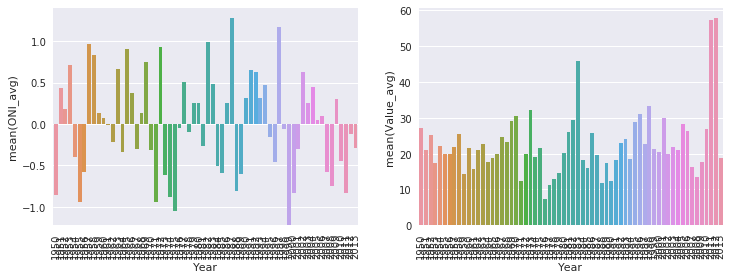

In [57]:
def plot_PRCP_ONI(df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.set_xticklabels(df['Year'])
    ax1.set_ylabel('ONI_avg')
    sns.barplot(x=df['Year'], y=df['ONI_avg'], ax=ax1)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax1.set_xticklabels(df['Year'])
    ax2.set_ylabel('PRCP_avg')
    sns.barplot(x=df['Year'], y=df['Value_avg'], ax=ax2)

plot_PRCP_ONI(df_new)

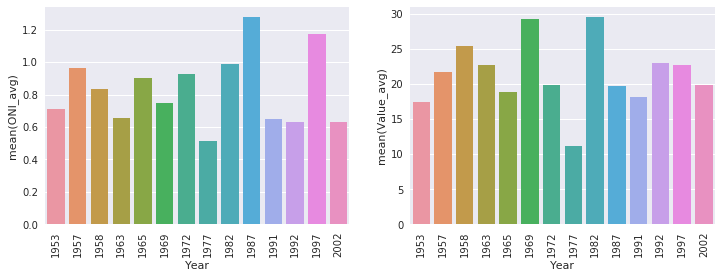

In [58]:
df2 = df_new[df_new['ONI_avg']>0.5]
plot_PRCP_ONI(df2)

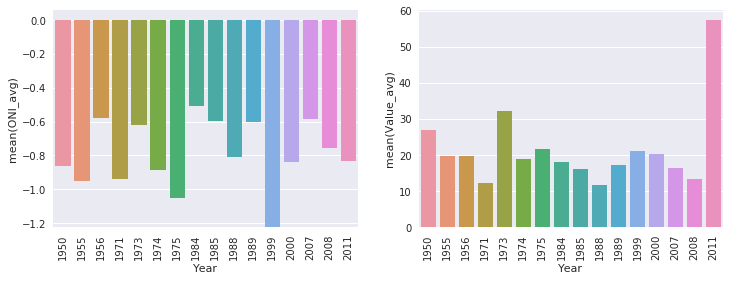

In [62]:
df3 = df_new[df_new['ONI_avg']<-0.5]
plot_PRCP_ONI(df3)

In [73]:
def plot_PRCP_ONI_Month(df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.set_xticklabels(df['Month'])
    ax1.set_ylabel('ONI_avg')
    sns.barplot(x=df['Mo'], y=df['ONI_avg'], ax=ax1)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax1.set_xticklabels(df['Year'])
    ax2.set_ylabel('PRCP_avg')
    sns.barplot(x=df['Year'], y=df['Value_avg'], ax=ax2)

plot_PRCP_ONI(df_new)

,Year,Value_day,Value_month,Value_avg,ONI_month,ONI_avg
107,2009,"[19.516, 19.5, 19.938, 20.141, 20.297, 20.438,...","[26.453, 50.719, 32.656, 16.047, 12.984, 2.210...",17.7656,"[-0.80, -0.69, -0.52, -0.24, 0.09, 0.35, 0.47,...",0.306667
108,2010,"[44.344, 45.344, 46.312, 47.375, 48.531, 49.5,...","[55.562, 50.812, 36.188, 28.266, 19.016, 7.210...",26.875,"[1.55, 1.31, 0.94, 0.44, -0.09, -0.59, -1.03, ...",-0.453333
109,2011,"[44.688, 44.125, 43.562, 42.969, 42.375, 42.06...","[42.219, 87.875, 120.38, 83.312, 54.969, 28.75...",57.375,"[-1.37, -1.09, -0.83, -0.64, -0.47, -0.38, -0....",-0.834167
110,2012,"[158.75, 162.38, 164.88, 167.12, 169.0, 170.75...","[166.88, 122.62, 107.69, 88.812, 40.969, 1.462...",57.7812,"[-0.81, -0.62, -0.50, -0.38, -0.18, 0.05, 0.27...",-0.126667
111,2013,"[67.0, 66.0, 65.188, 64.312, 63.469, 62.594, 6...","[52.531, 23.031, nan, nan, nan, nan, nan, nan,...",18.8906,"[-0.38, -0.33, -0.24, -0.21, -0.27, -0.34, -0....",-0.294167


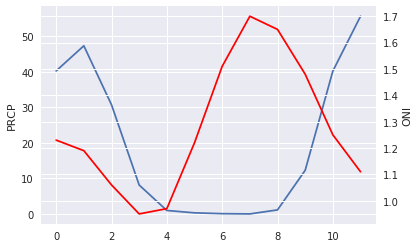

In [98]:
maxoni = np.argmax(df_new['ONI_avg'])
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(df_new['Value_month'][maxoni])
ax1.set_ylabel('PRCP')

ax2 = ax1.twinx() 
ax2.plot(df_new['ONI_month'][maxoni], 'r')
ax2.set_ylabel('ONI')

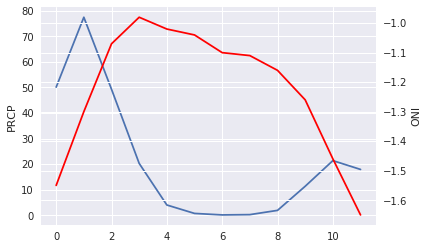

In [100]:
minoni = np.argmin(df_new['ONI_avg'])
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(df_new['Value_month'][minoni])
ax1.set_ylabel('PRCP')

ax2 = ax1.twinx() 
ax2.plot(df_new['ONI_month'][minoni], 'r')
ax2.set_ylabel('ONI')

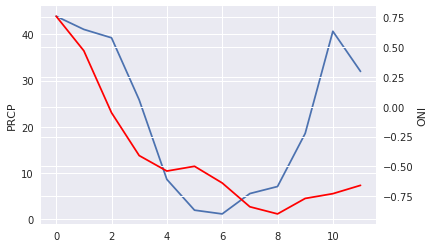

In [110]:
minoni = 52
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(df_new['Value_month'][minoni])
ax1.set_ylabel('PRCP')

ax2 = ax1.twinx() 
ax2.plot(df_new['ONI_month'][minoni], 'r')
ax2.set_ylabel('ONI')

In [107]:
df_new['ONI_avg']

48    -0.860000
49     0.430833
50     0.174167
51     0.713333
52    -0.400833
53    -0.948333
54    -0.577500
55     0.960833
56     0.832500
57     0.136667
58     0.068333
59    -0.016667
60    -0.215000
61     0.657500
62    -0.341667
63     0.900833
64     0.375000
65    -0.306667
66     0.135000
67     0.745000
68    -0.320000
69    -0.940000
70     0.927500
71    -0.617500
72    -0.886667
73    -1.052500
74    -0.049167
75     0.511667
76    -0.098333
77     0.250833
         ...   
82    -0.505833
83    -0.598333
84     0.253333
85     1.276667
86    -0.810833
87    -0.605000
88     0.315000
89     0.646667
90     0.630833
91     0.312500
92     0.475000
93    -0.160000
94    -0.460000
95     1.170833
96    -0.057500
97    -1.225000
98    -0.835833
99    -0.308333
100    0.630833
101    0.250833
102    0.446667
103    0.043333
104    0.100833
105   -0.581667
106   -0.755000
107    0.306667
108   -0.453333
109   -0.834167
110   -0.126667
111   -0.294167
Name: ONI_avg, dtype: fl